In [2]:
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley
from plot import plot
import random
import numpy as np
import pandas as pd

Example Series

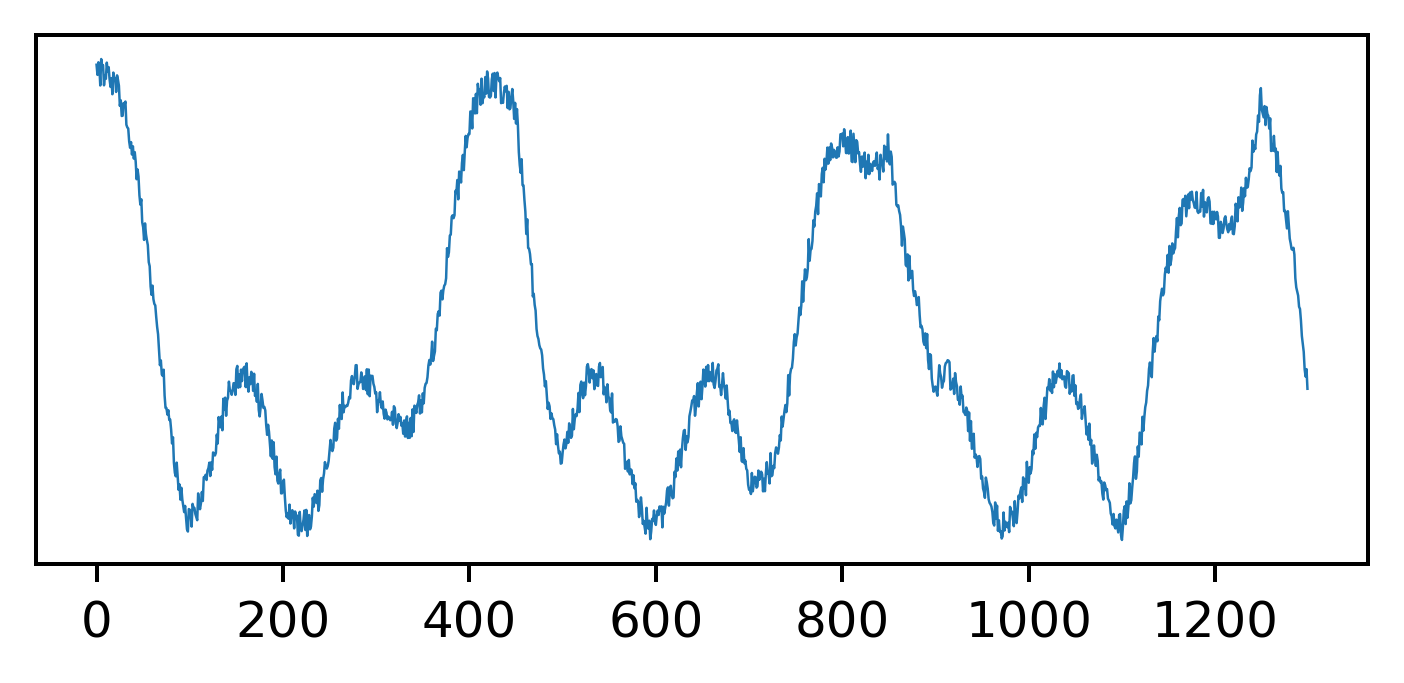

In [3]:
generator = np.random.default_rng(42)

series = np.concatenate([
  np.array(generator.uniform(-0.2, 0.2, 100)) + np.linspace(0, 5, 100)[::-1],
  
  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],

  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],

  np.array(generator.uniform(-0.2, 0.2, 200)),
  np.array(generator.uniform(-0.2, 0.2, 150)) + np.linspace(0, 5, 150),
  np.array(generator.uniform(-0.2, 0.2, 50)) + np.linspace(0, 5, 50)[::-1],
])
series = series + np.sin([i/20 for i in range(len(series))])

plot(series, show_axis=(True, False))

Creating XTSTree

In [4]:
xtstree = XTSTreePageHinkley(
  # Stopping condition, adf is the AdFuller test, and stop_val increases the threshold for a series to be non-stationary. The bigger stop_val gets, the harder it is for a cut to be made
  stop_condition='adf',
  stop_val=0,
  # Max iterations during the binary search before it decides between the cuts found
  max_iter=100,
  # Minimum distance between cuts so multiple cuts aren't created close to drastic changing points
  min_dist=int(len(series)/100),
  # Page-Hinkley parameters
	min_instances=30,
	delta=0.005,
	alpha=1 - 0.0001,
	# Starting value for Page-Hinkley threshold before binary search is used
	starting_threshold=50.0,
)

Creating cuts for the series

Não achei só um corte, escolhendo corte que gera maior pontuação, 881, 329.8689022092168, 2, 2


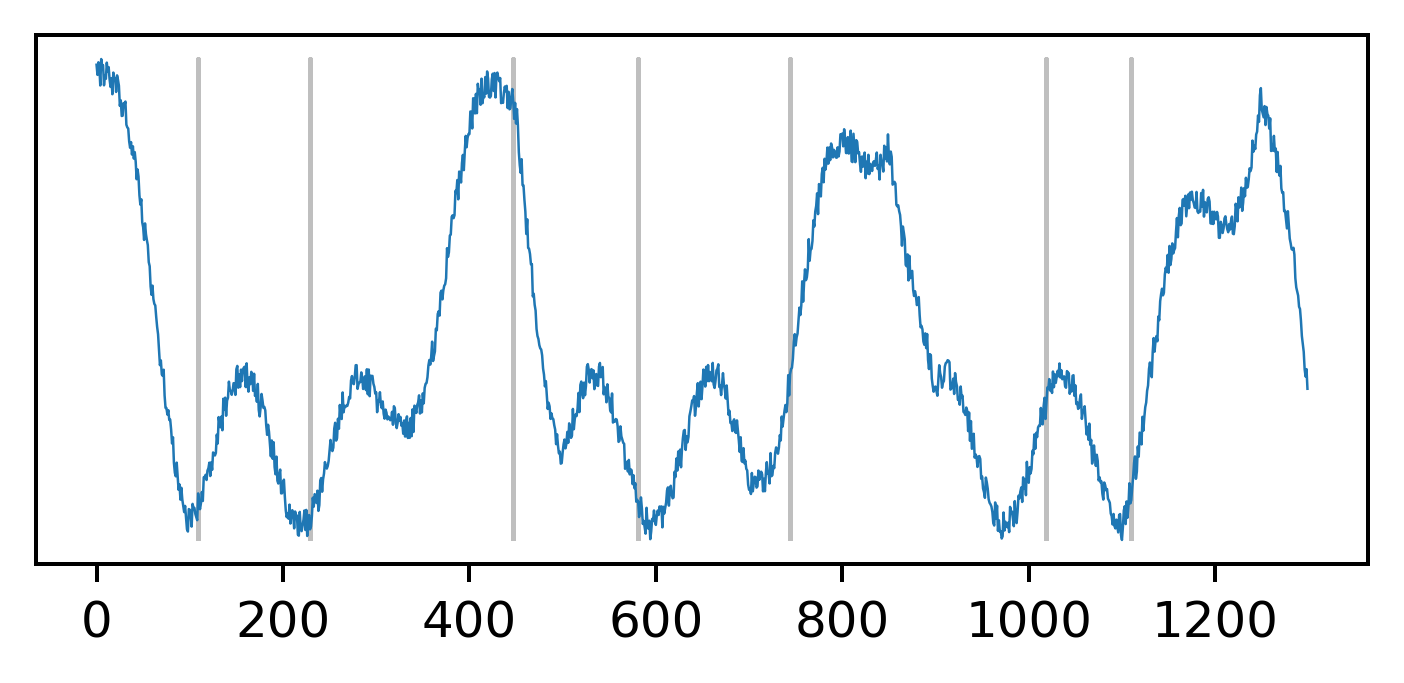

In [5]:
# Creates the splits based on the series
xtstree = xtstree.create_splits(series)

# Gets a list of the cut positions for the series
cuts = xtstree.cut_points()

plot(series, divisions=cuts, show_axis=(True, False))

Plotting cuts labelled by depth

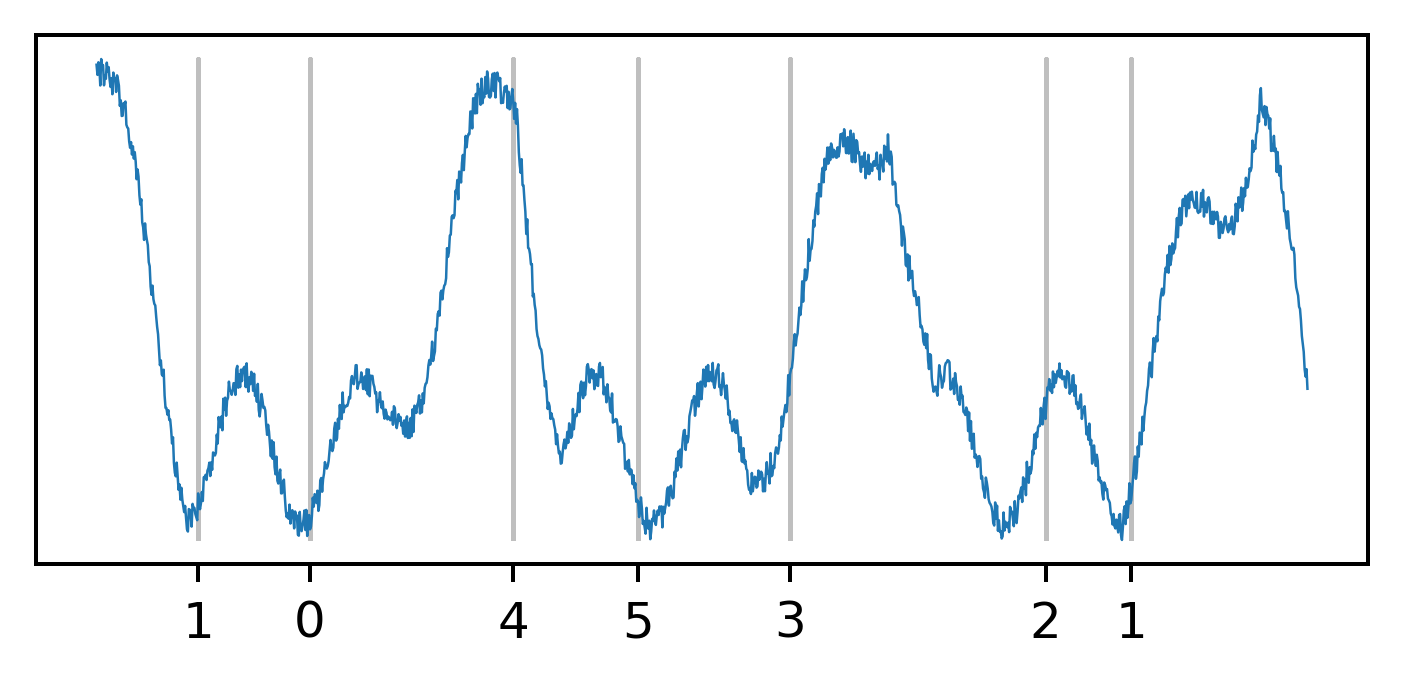

In [6]:
labels = []
for depth, d_cuts in xtstree.get_cuts_by_depth().items():
  for cut in d_cuts:
    labels.append({'x': cut, 'label': depth})

plot(series, divisions=cuts, show_axis=(True, False), labels=labels)

Iterating through series' cuts

In [7]:
for start, finish in zip([0, *cuts], [*cuts, len(series)]):
  print(len(series[start:finish]))
	# plot(series[start:finish], show_axis=(True, False))

109
120
218
134
163
274
92
190


Tree's heatmap

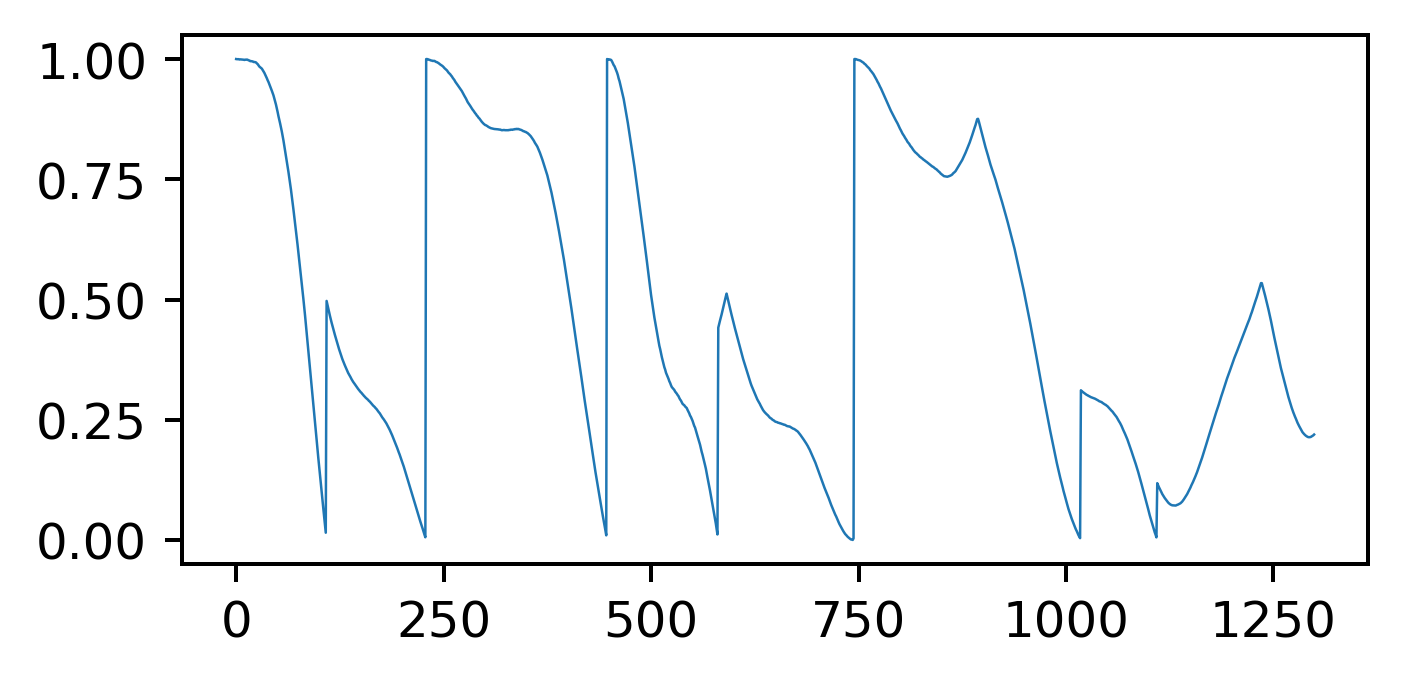

In [8]:
# The XTSTree stores a heatmap indicating how close the tree is to a cut
# When it hits 0, the cutting process starts

plot(xtstree.get_heatmap())

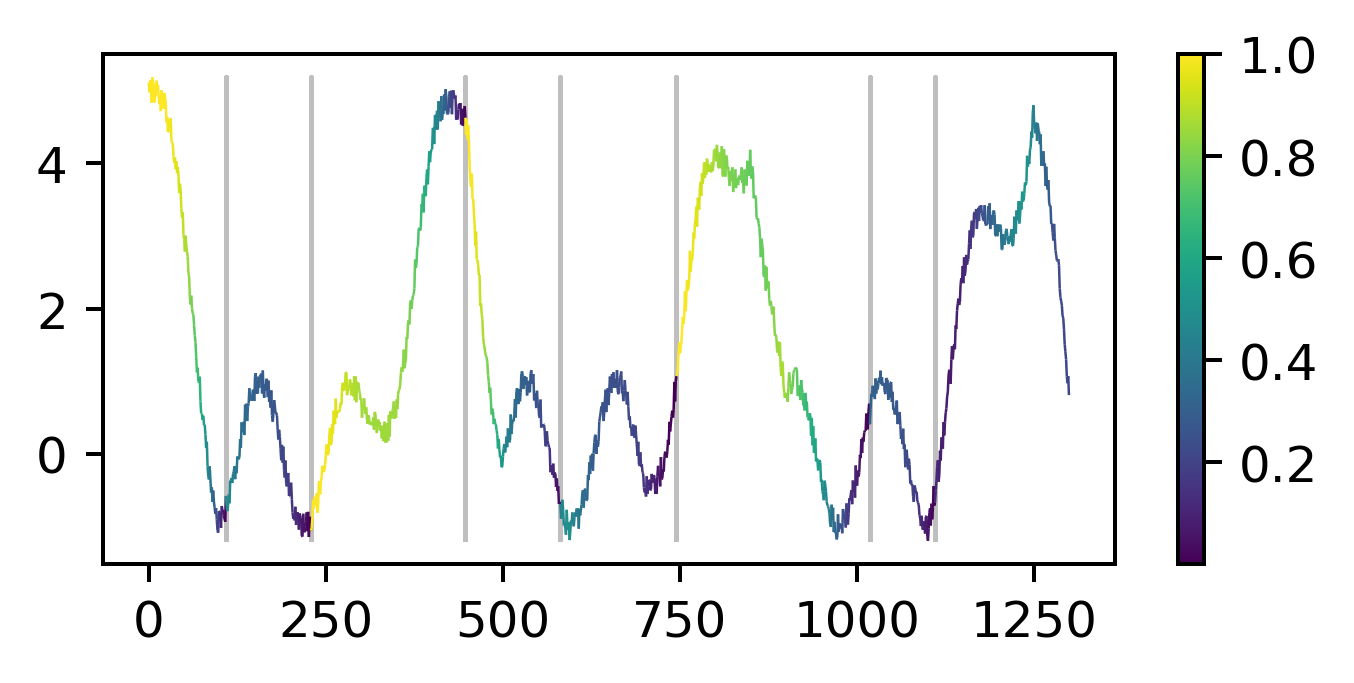

In [9]:
plot(series, color_gradient=xtstree.get_heatmap(), divisions=cuts)

Summary containing all cuts made by the XTSTree, divided by depth and with unique identifiers

In [10]:
xtstree.summary()

{0: [{'Root': 229}],
 1: [{'L': 109}, {'R': 1110}],
 2: [{'RL': 1018}],
 3: [{'RLL': 744}],
 4: [{'RLLL': 447}],
 5: [{'RLLLR': 581}]}

Returns segments from the series using only cuts from a specified depth

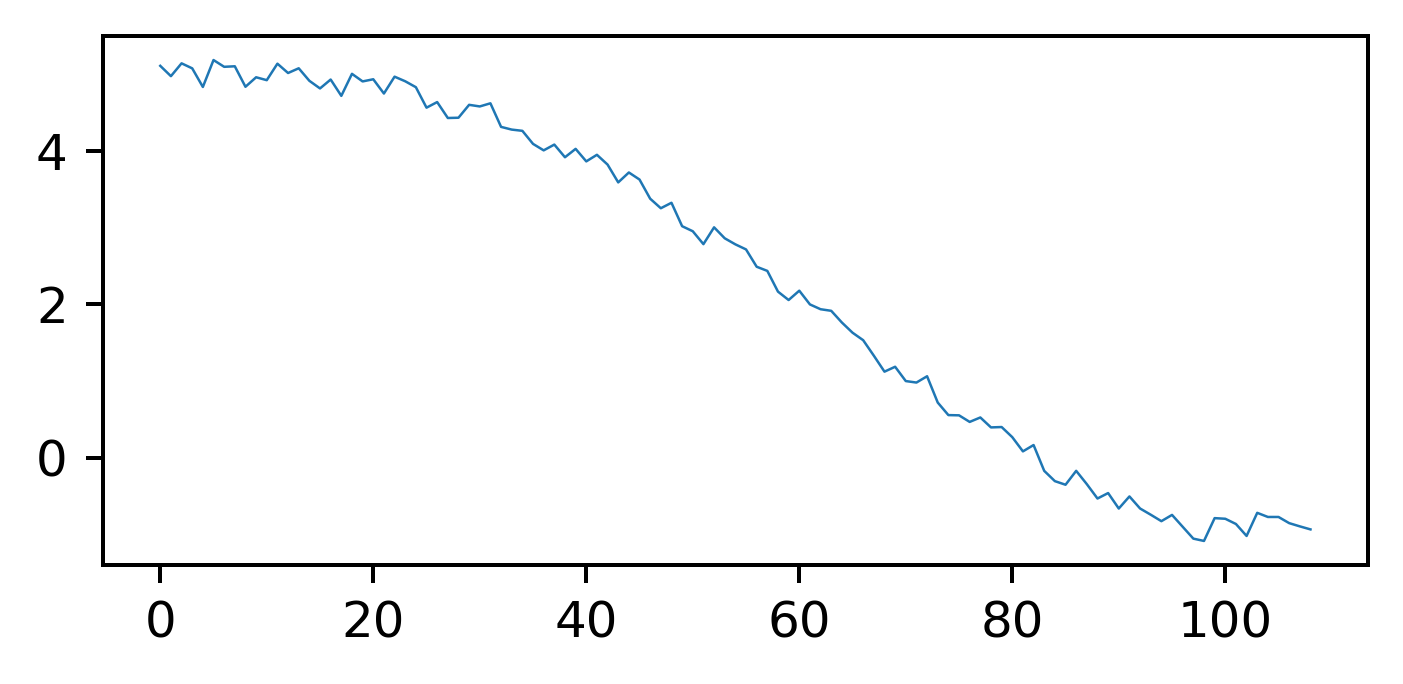

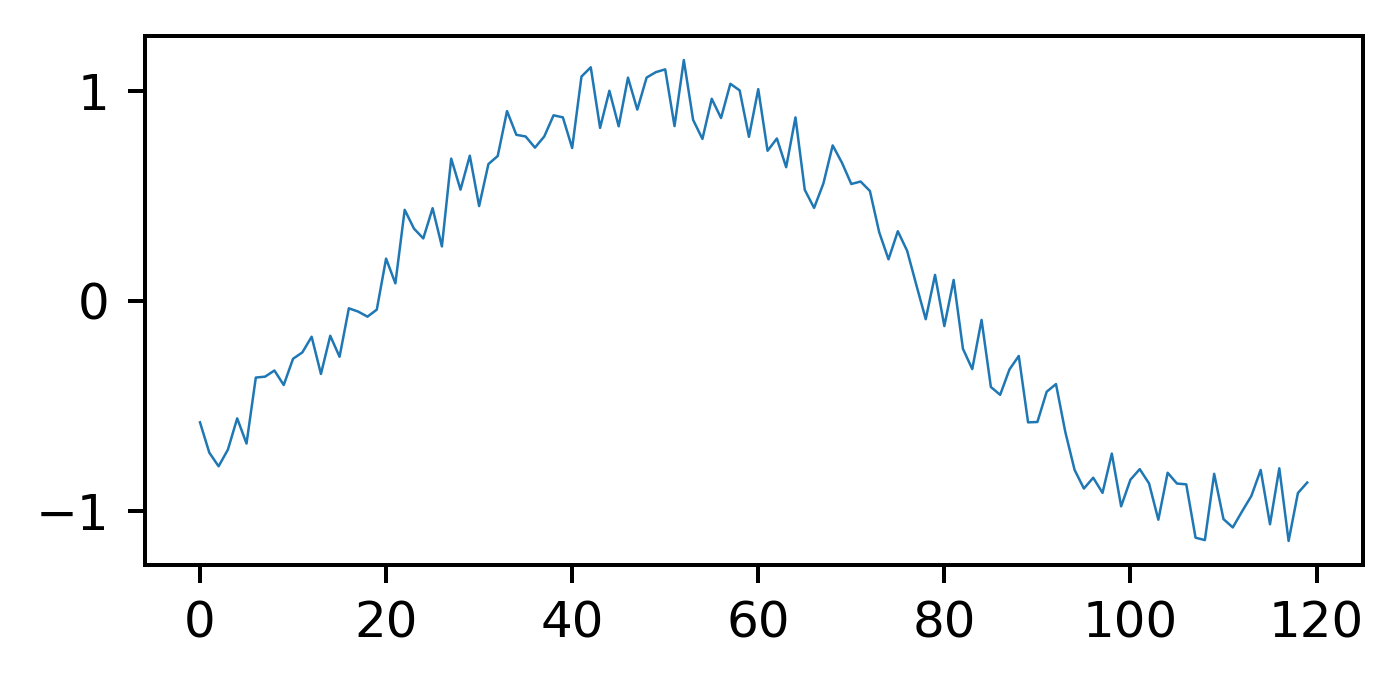

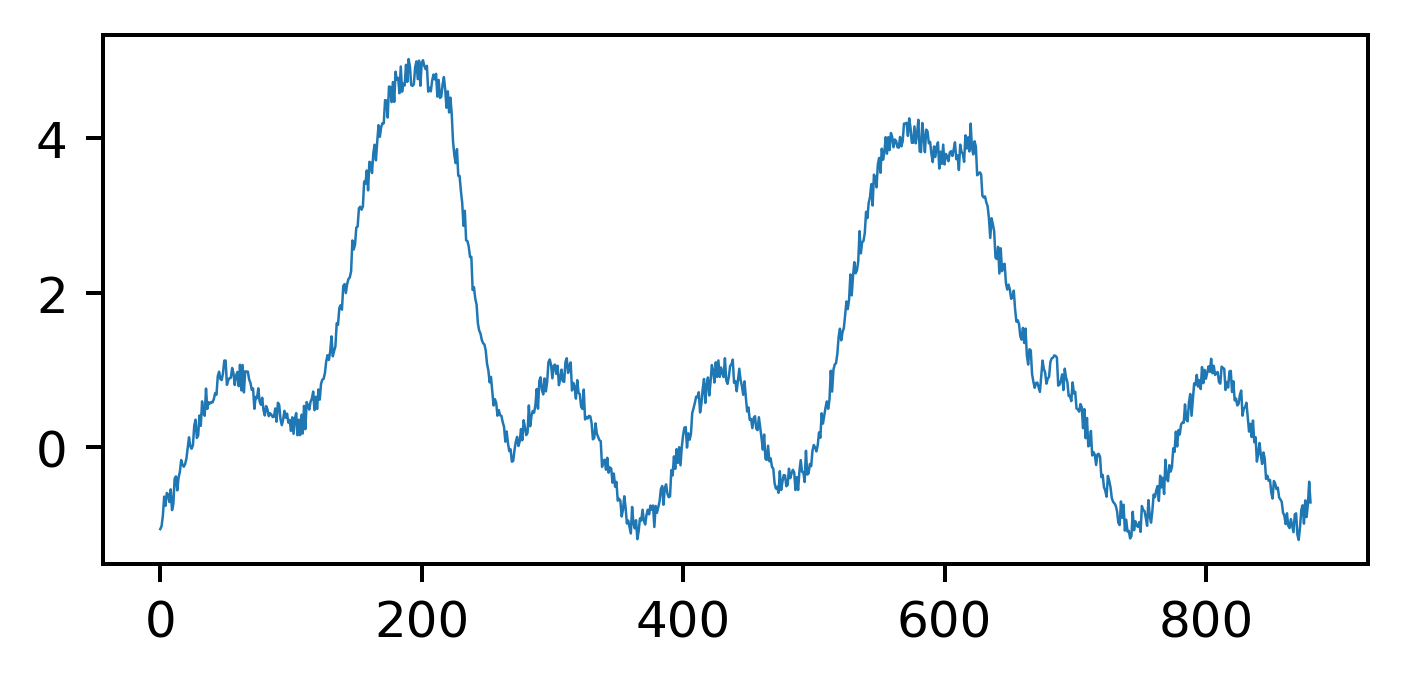

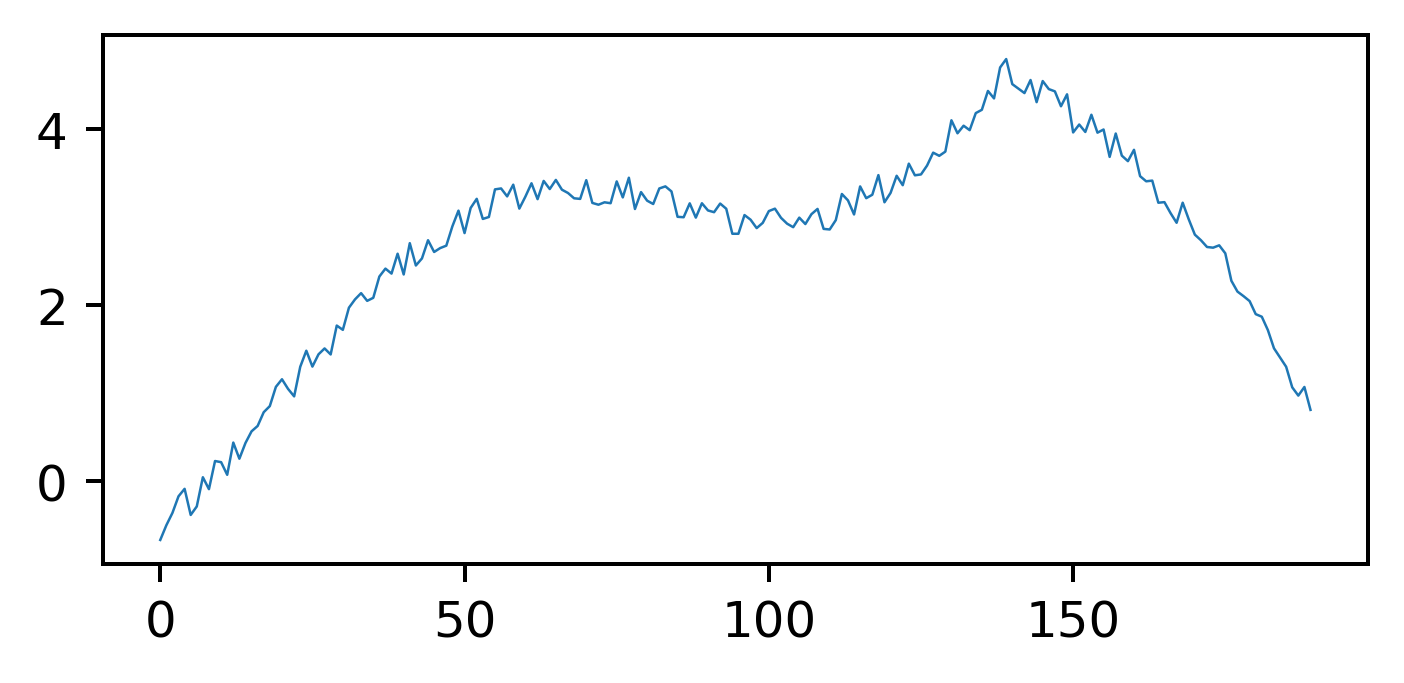

In [11]:
depth = 1
series_by_depth = xtstree.cut_series_by_depth(series)[depth]
for s in series_by_depth:
	plot(s)

Other series

In [12]:
def formula1(x):
  if x <= -2:
    return 1
  elif x <= 0:
    return -1
  elif x <= 2:
    return 2
  else:
    return 1
  
def formula2(x):
  if x <= -2:
    return 1
  elif x <= 0:
    return -(x + 1)
  elif x <= 2:
    return x-1
  else:
    return 1

def formula3(x):
  if x <= 0:
    return 1
  else:
    return np.square(x)
  
def formula4(x):
  if x <= 1:
    return x
  else:
    return np.square(x)
  
def formula5(x):
  if x < -0.4:
    return pow(x, 5) - 2*pow(x, 3) + x
  elif x < 0:
    return pow(x, 4) + pow(x, 3) + pow(x, 2) + x
  else:
    return pow(x, 6) - 2*pow(x, 4) + pow(x, 2)
  
def formula6(x):
  if x <= (-2*np.pi)/3:
    return 3*np.sin(2*x+1)
  elif x <= (2*np.pi)/3:
    return np.sin(2*x+1)
  else:
    return 2*np.sin(1.5*x+3)
    

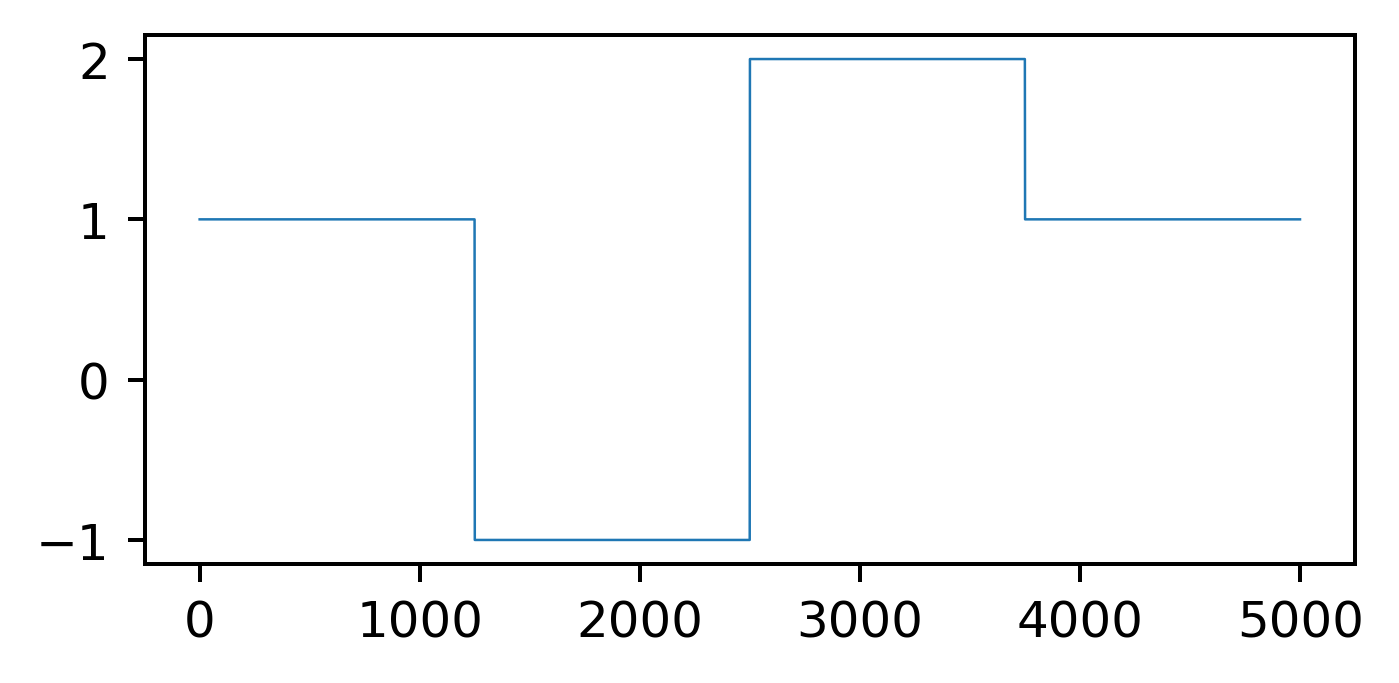

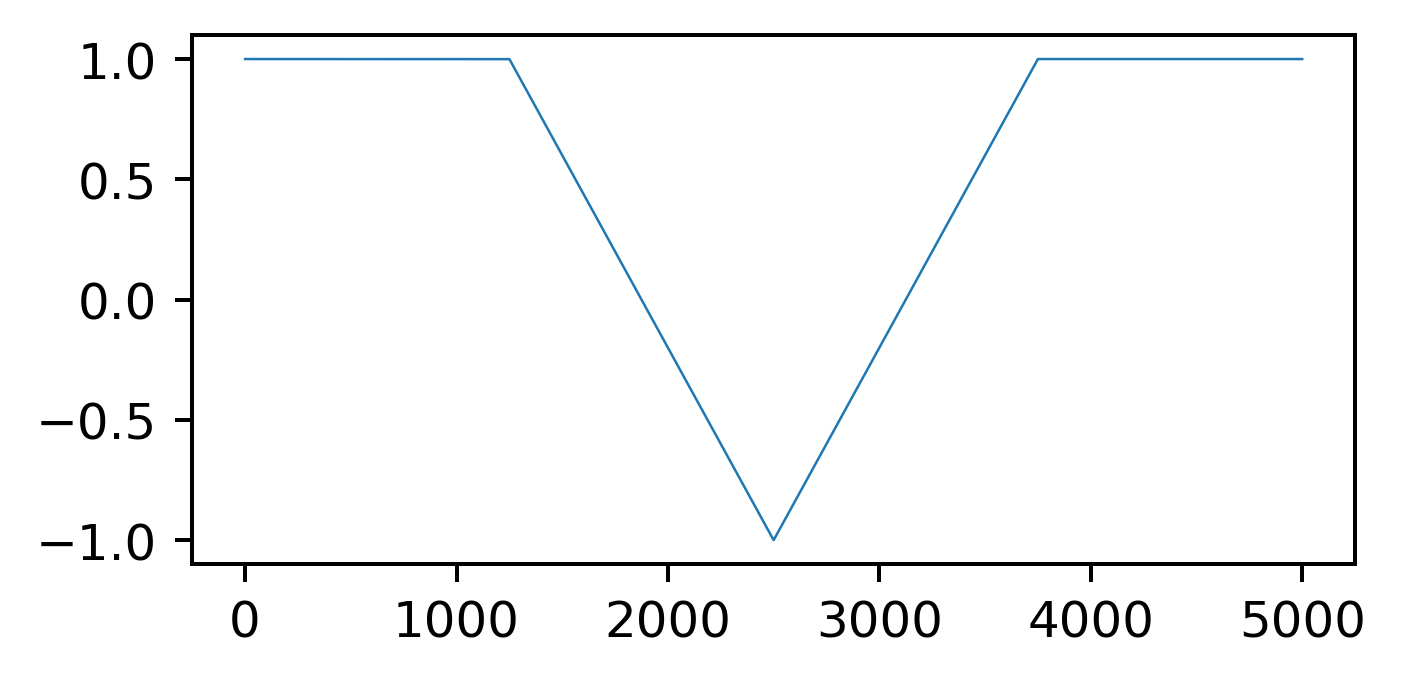

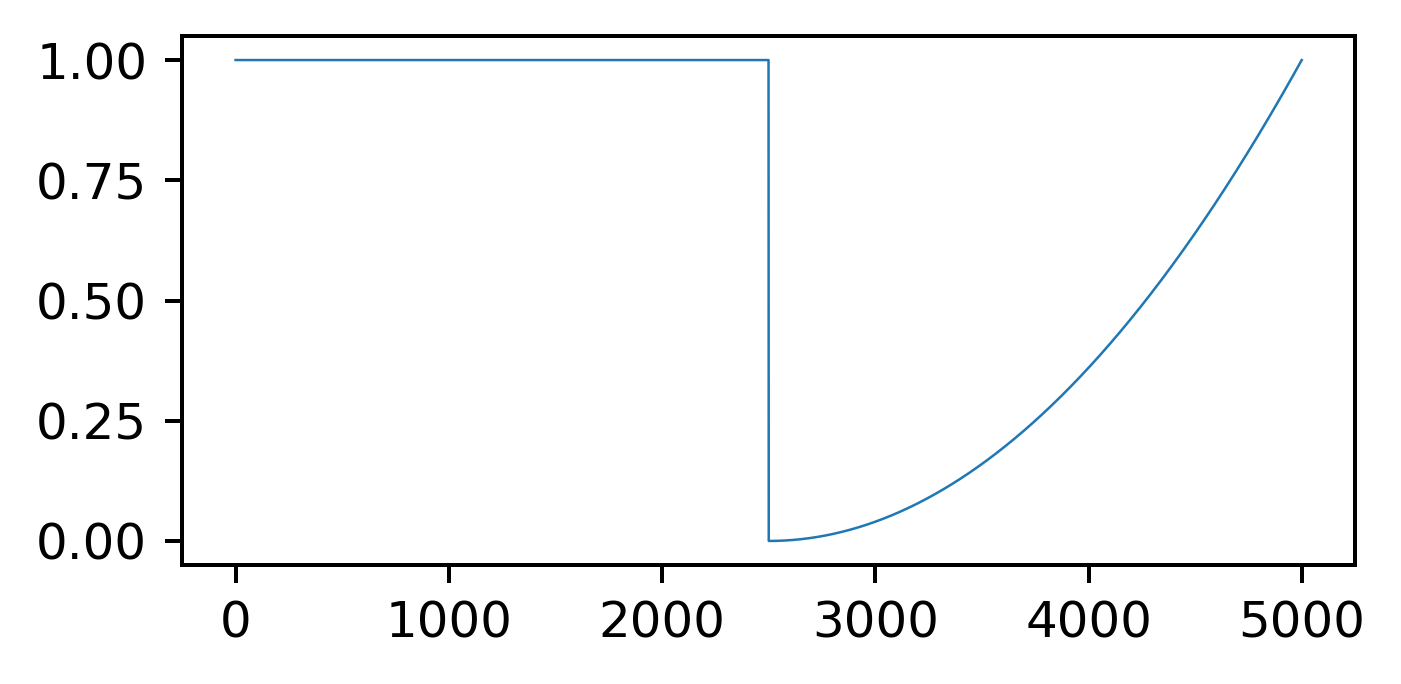

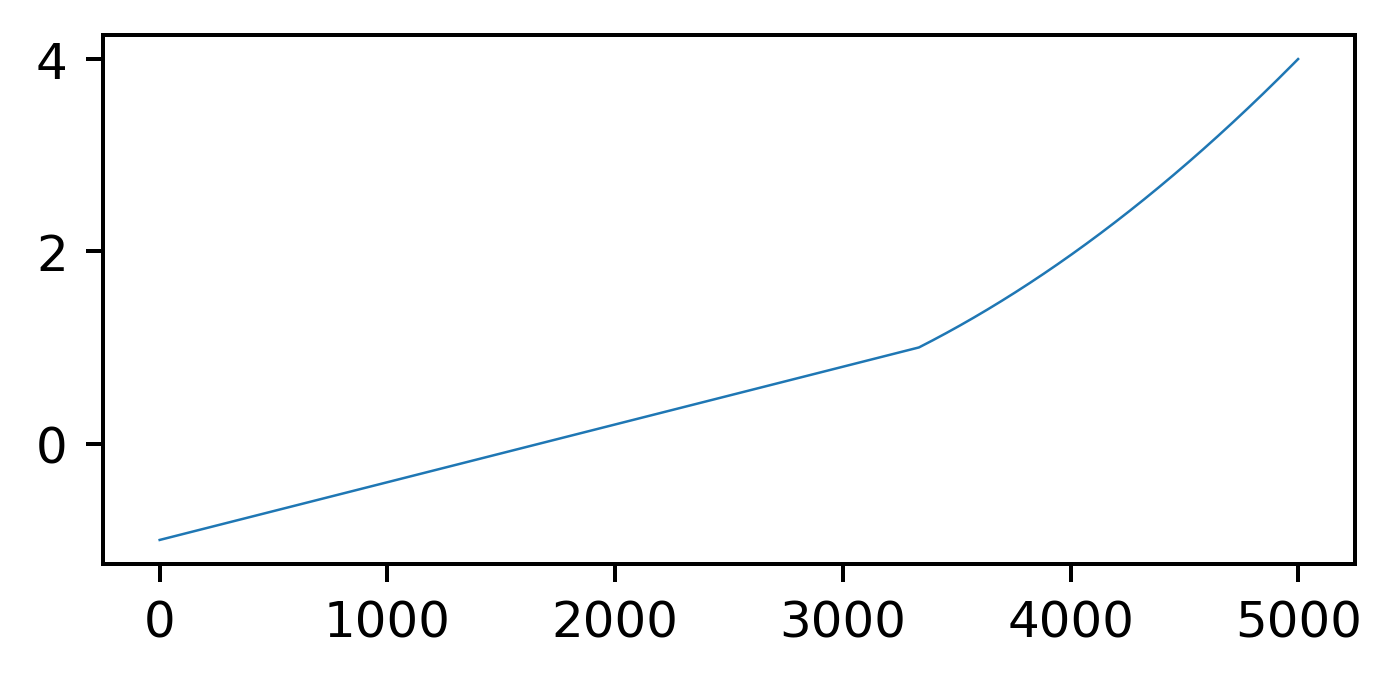

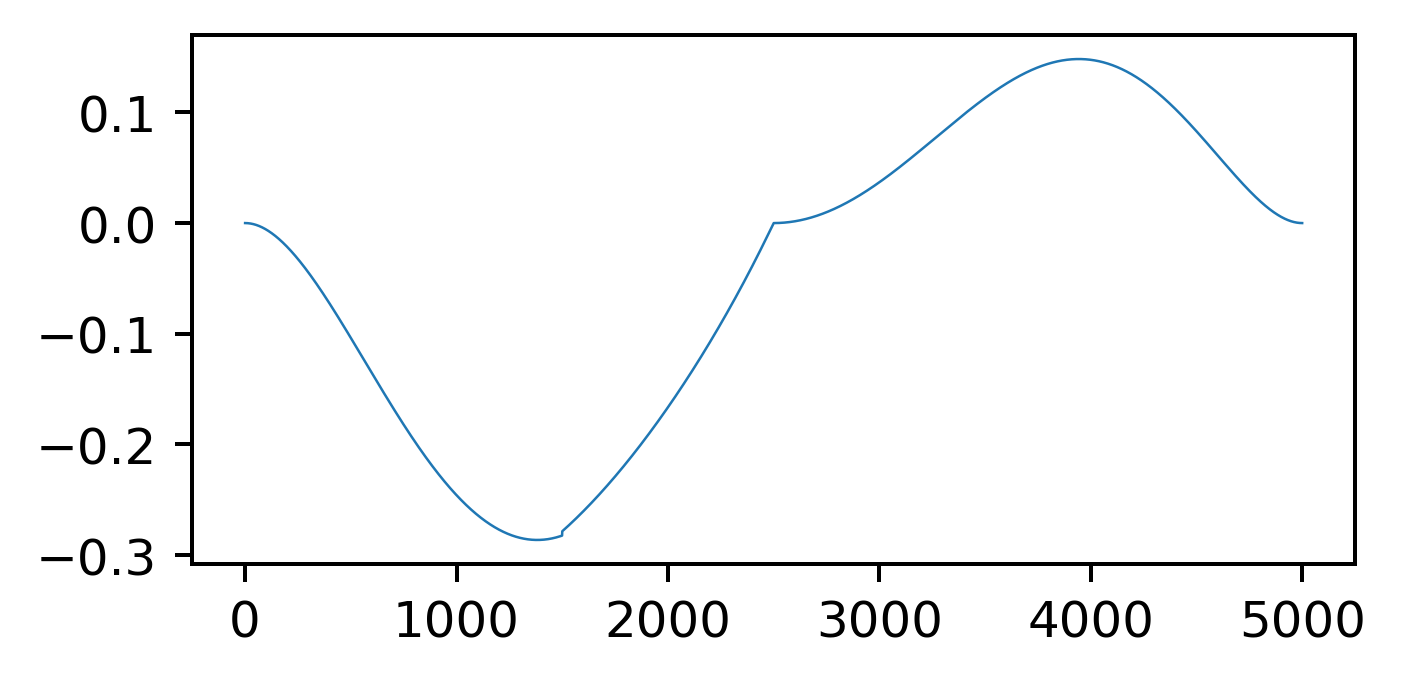

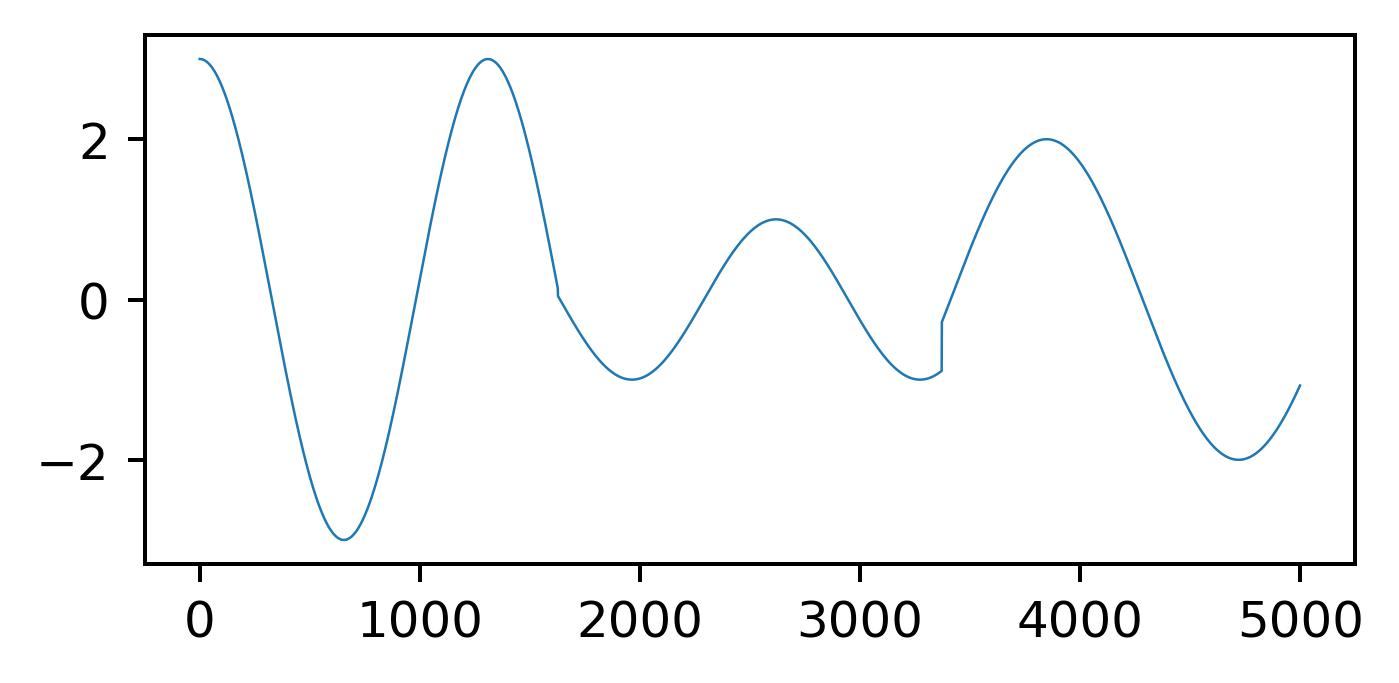

(None, None, None, None, None, None)

In [13]:
ts1 = [formula1(x) for x in np.linspace(-4,4, num=5000)]
ts2 = [formula2(x) for x in np.linspace(-4,4, num=5000)]
ts3 = [formula3(x) for x in np.linspace(-1,1, num=5000)]
ts4 = [formula4(x) for x in np.linspace(-1,2, num=5000)]
ts5 = [formula5(x) for x in np.linspace(-1,1, num=5000)]
ts6 = [formula6(x) for x in np.linspace(-6,6, num=5000)]
plot(ts1), plot(ts2), plot(ts3), plot(ts4), plot(ts5), plot(ts6)

In [27]:
def apply_xtstree(series, stop_condition='depth', stop_val=3, max_iter=100, min_instances=15, delta=0.005, alpha=1 - 0.0001, starting_threshold=50.0):
	xts = XTSTreePageHinkley(stop_condition=stop_condition, stop_val=stop_val, max_iter=max_iter, min_instances=min_instances, delta=delta, alpha=alpha, starting_threshold=starting_threshold)

	# Creates the splits based on the series
	xts = xts.create_splits(series)

	# Gets a list of the cut positions for the series
	cuts = xts.cut_points()

	plot(series, divisions=cuts, show_axis=(True, False))
	return xts

In [15]:
from river.drift import PageHinkley

def apply_ph(series, min_instances, delta, threshold):
  cut_pos = []
  heatmap_increase = []
  heatmap_decrease = []
  ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold)
  # Rever funcionamento do min_dist junto dos heatmaps
  for i, val in enumerate(series):
    ph.update(val)
    if ph.drift_detected:
      cut_pos.append(i)
  plot(series, title=len(cut_pos), divisions=cut_pos, show_axis=(True, False))
  return cut_pos

def apply_ph_auto(series, min_instances, delta):
  for threshold in range(1,500,1):
    cut_pos = []
    heatmap_increase = []
    heatmap_decrease = []
    ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold)
    # Rever funcionamento do min_dist junto dos heatmaps
    for i, val in enumerate(series):
      ph.update(val)
      heatmap_increase.append(threshold - (ph._sum_increase - ph._min_increase))
      heatmap_decrease.append(threshold - (ph._sum_increase - ph._min_increase))
      if ph.drift_detected:
        cut_pos.append(i)
    if len(cut_pos) == 1:
      break
  plot(series, title=len(cut_pos), divisions=cut_pos, show_axis=(True, False), color_gradient=heatmap_increase)
  plot(series, title=len(cut_pos), divisions=cut_pos, show_axis=(True, False), color_gradient=heatmap_decrease)
  return cut_pos

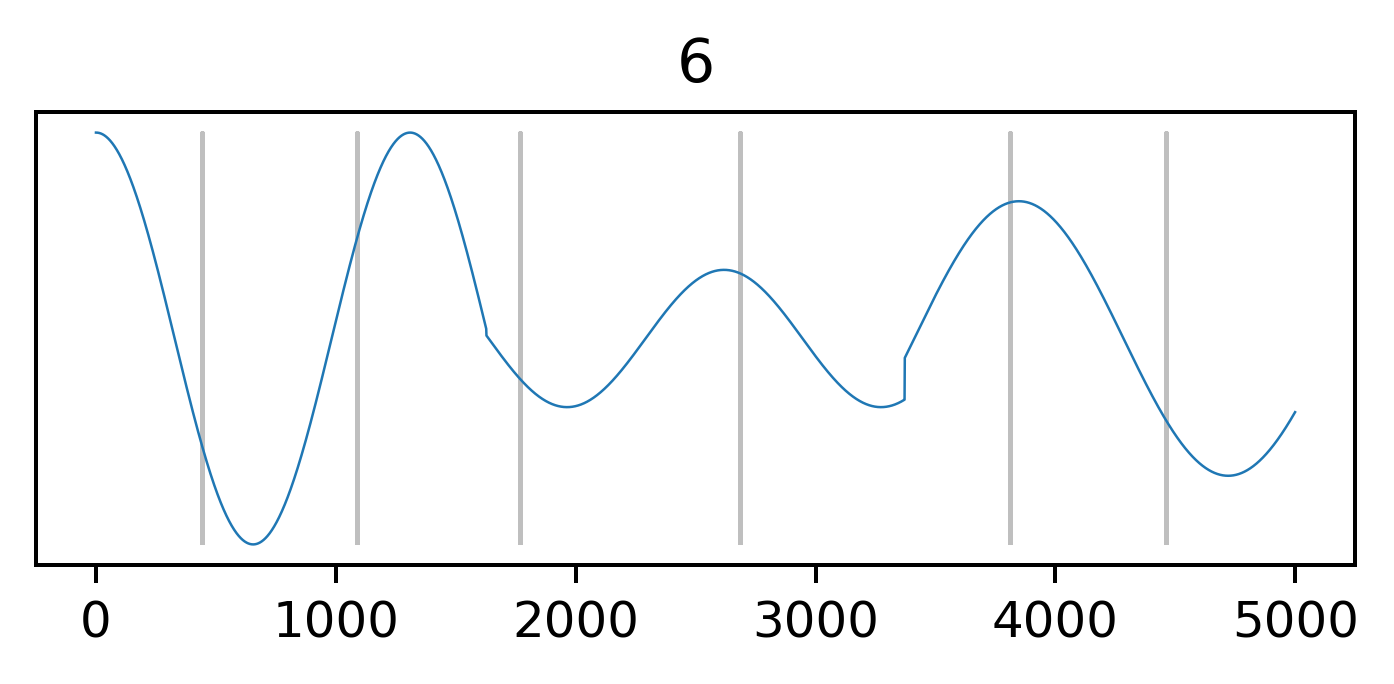

[444, 1088, 1766, 2687, 3811, 4459]


In [16]:
# print(apply_ph(ts1, min_instances=10, delta=0.005, threshold=1))
# print(apply_ph(ts2, min_instances=10, delta=0.8, threshold=10))
# print(apply_ph(ts3, min_instances=10, delta=0.8, threshold=1))
# print(apply_ph(ts4, min_instances=10, delta=0.05, threshold=5))
# print(apply_ph(ts5, min_instances=10, delta=0.005, threshold=50))
print(apply_ph(ts6, min_instances=10, delta=0.005, threshold=500))

In [22]:
from pysr import PySRRegressor
def get_regressor(criteria, pop_n, pop_size, iterations):
	return PySRRegressor(
		binary_operators=['+', '-', '*', '/'],
		unary_operators=[],
		niterations=iterations,
		populations=pop_n,
		population_size=pop_size,
		progress=False,
		model_selection=criteria,
		verbosity = 0,
		temp_equation_file=False
	)

In [23]:
model1 = get_regressor(criteria='accuracy', pop_size=50, pop_n=10, iterations=10)
model2 = get_regressor(criteria='accuracy', pop_size=100, pop_n=10, iterations=10)

In [19]:
model1.fit([[x] for x in np.linspace(-4,4, num=5000)], [[x] for x in  ts1], variable_names=['index'])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\pysr\sr.py:1215: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.7500191   
	1         0.053160                                         sin(index)   
	2         0.338728                          (sin(index) - -0.8416149)   
	3         0.014752                     (sin(index) - sin(-0.8416149))   
	4         0.063039             (sin(-0.19108765 + index) - -0.649052)   
	5         0.139357              (sin(sin(index) + index) - -0.749977)   
	6         0.091318         (sin(sin(sin(index)) + index) - -0.749977)   
	7         0.557310  ((sin(sin(index) + index) - -0.38875818) * 1.9...   
	8         0.264991  (sin(sin(sin(index) + index) - -0.37677068) * ...   
	9         0.103265  (sin(sin(sin(sin(index)) + index) - -0.3962315...   
	10        0.057331  (sin(sin(sin(sin(sin(index) + index)) - -0.322...   
	11        0.385828  (sin(sin(sin(sin(index) + index) * 2.134916) -...   
	12      

In [20]:
yhat = model1.predict([[x] for x in np.linspace(-4,4, num=5000)])

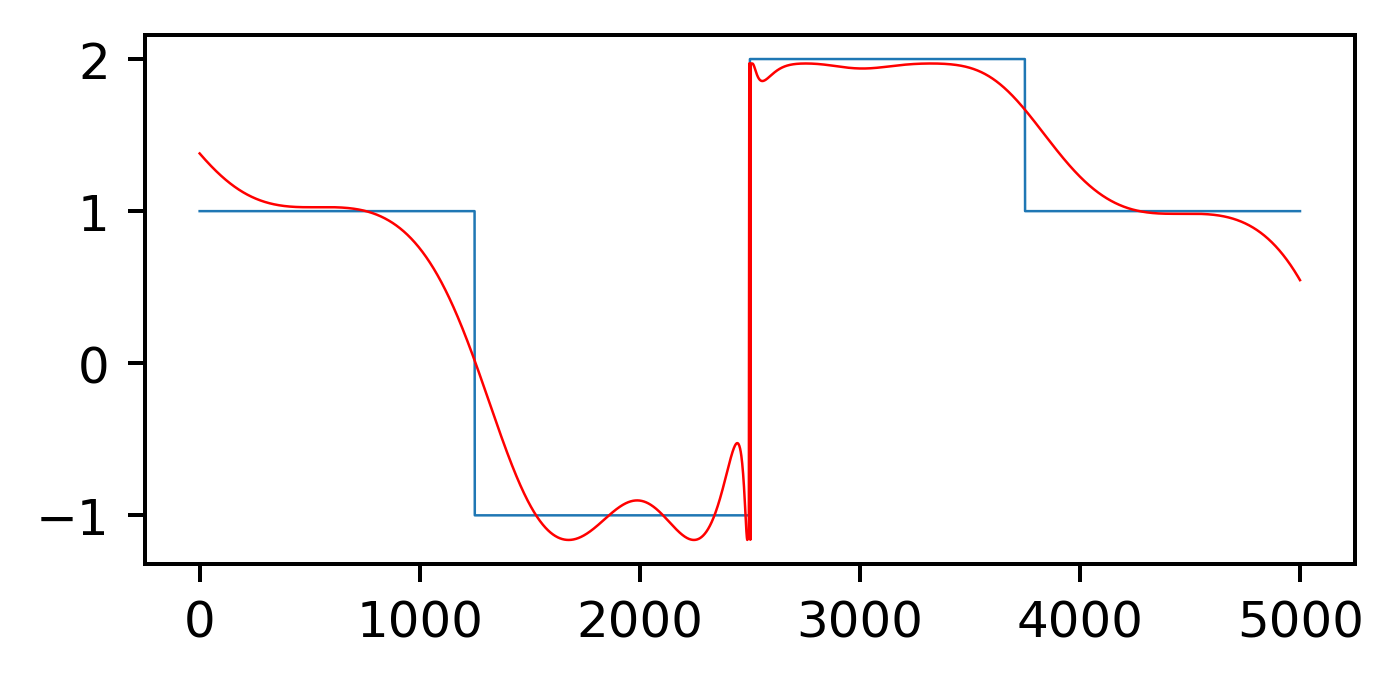

In [21]:
plot(ts1, sec_plots=[yhat])

Não achei nenhum corte em 100 iterações, nó tem que ser folha
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Série pequena demais para adf, deve terminar o corte
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Série pequena demais para adf, deve terminar o corte
Não achei nenhum corte em 100 iterações, nó tem que ser folha
Série pequena demais para a

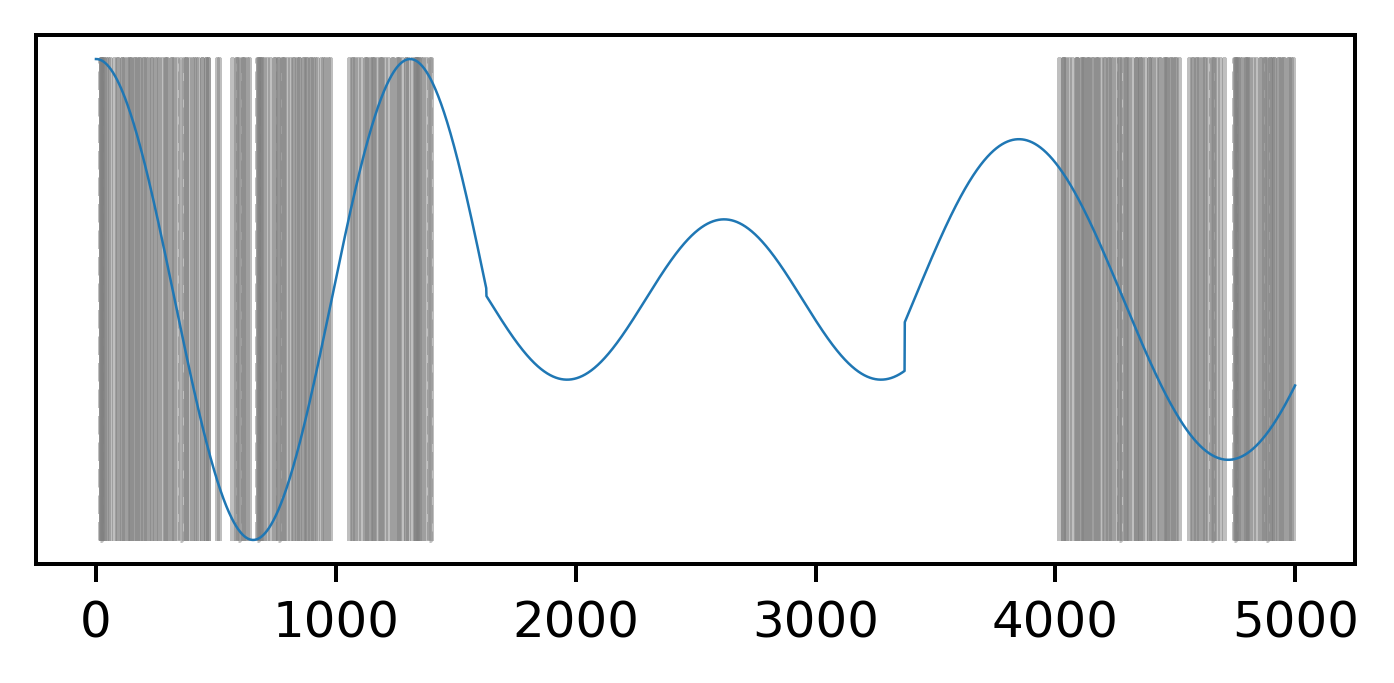

: 

In [40]:
cuts = apply_xtstree(ts6, stop_condition='adf', stop_val=0, delta=0.005)